`Last update at 2021-03-16`

# Background

## Rounds to test
```
Round 1: 60 MAGs; 39 MS/MS-BGC links (1 correct link)
Round 2: 279 genomes/MAGs; 1 MS/MS-BGC links (0 correct link)
Round 3: 279 genomes/MAGs and 589 metagenomes; 16 MS/MS-BGC links (8 correct links)
```

## Outline

```
    3) Creating BGC fingerprints and running KNN:
    3.1) Processing NPLinker ground truth data and loading ENA_dict;
    3.2) Running BiG-SCAPE in a external server; (estimated runtime of 3h)
    3.3) Concatenating BiG-SCAPE results;
    3.4) Processing BiG-SCAPE data;
    3.5) Renaming BGCs in dataframe and dictionary;
    3.6) Creating affinity dataframe;
    3.7) Filtering affinity dataframe to create traning and testing dataframes;
    3.8) Processing KNN;
    3.9) Running cross-validation;
    3.10) Plotting fingerprints.
    
```

In [1]:
import pandas as pd
import time
import glob
import numpy as np
import csv
import subprocess
import glob
import os
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.model_selection import cross_val_score
from pyteomics import mgf, auxiliary

# 3. Creating BGC fingerprints and running KNN

## 3.1. Loading ENA_dict

In [2]:
ena_df = pd.read_csv('./temp_files/ena_dict-round3-210315.csv',sep=',',names=['ERR_code','ERXS_code'])

ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))

## 3.2. Running BiG-SCAPE in a external server

```
python /home/gerwick-lab/Desktop/bigscape/BiG-SCAPE/bigscape.py \
-i /home/gerwick-lab/Desktop/bigscape/popd_antiSMASH/ \
-o /home/gerwick-lab/Desktop/bigscape/bigscape_outputs_210124/ \
-c 12 --include_singletons --pfam_dir /home/gerwick-lab/Desktop/bigscape/
```

## 3.3. Concatenating BiG-SCAPE results

In [3]:
# %%bash

# cd ./bigscape_outputs_210124/

# rm ./bigscape_all_c030.txt
# find ./network_files/2021-01-24_15-45-51_hybrids_glocal/ -type f -name *_c0.30.network | cat > ./network_files.txt
# while read line; do cat $line >> ./pre_bigscape_all_c030.txt; done < ./network_files.txt
# awk '/Clustername/&&c++>0 {next} 1' ./pre_bigscape_all_c030.txt >> ./bigscape_all_c030.txt

For stats on the annotated metagenomes, see notebook 4 - GCF metadata

## 3.4. Processing BiG-SCAPE data

In [4]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = get_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

In [5]:
input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/bigscape_outputs_210124_round3/bigscape_all_c030.txt"

bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)

# to convert from distance to similarity:
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GL383688.1.region001,GL383923.1.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,c00528_NODE_52...region001,c00951_NODE_95...region001,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,c05228_NODE_52...region001,c05977_NODE_59...region001,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,c00702_NODE_70...region001,c01700_NODE_17...region001,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,c01177_NODE_11...region001,c01186_NODE_11...region001,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [6]:
len(bigscape_dict)

458

## 3.5. Renaming BGCs in dataframe and dictionary

In [7]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file and '._' not in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Volumes/TFL190831/ming_output/antismash/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

len(gbk_list),len(new_name_list)

(13848, 13848)

In [8]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    if 'BGC' in bigscape_df['Clustername_1'].loc[i]:
        new_col1.append(bigscape_df['Clustername_1'].loc[i])
    else:
        new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    if 'BGC' in bigscape_df['Clustername_2'].loc[i]:
        new_col2.append(bigscape_df['Clustername_2'].loc[i])
    else:
        new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GCA_000144525.region001,GCA_000144855.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,ERR2239627_contigs.region001,ERR2239795_contigs.region003,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,ERR3941375_contigs.region009,ERR3941223_contigs.region010,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,ERR2239604_contigs.region004,ERR3941249_contigs.region003,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,ERR2239564_contigs.region008,ERR3946830_contigs.region007,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [9]:
bigscape_dict2 = defaultdict(list)

for key in bigscape_dict:
    for value in bigscape_dict[key]:
        if 'BGC' in value:
            bigscape_dict2[key].append(value)
        else:
            if 'ERR' in name_dict[value]:
                bigscape_dict2[key].append(name_dict[value].split('_')[0])
            else:
                bigscape_dict2[key].append(name_dict[value])
        
len(bigscape_dict2)

458

## 3.6. Creating affinity dataframe

In [10]:
def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split(".")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    return training_df,row_names

In [11]:
bgcs_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split(".")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)

affinity_df.shape

(2869, 842)

In [12]:
!ls -d /Volumes/TFL190831/ming_output/antismash/*/ | wc -l

    1766


In [13]:
!ls -d /Volumes/TFL190831/ming_output/antismash/ER*/ | wc -l

    1034


In [14]:
affinity_df[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098_contigs,ERR2239119_contigs,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [15]:
new_affinity_names = []

for item in list(affinity_df.columns):
    if '_contigs' in item:
        new_affinity_names.append(item.split('_')[0])
    else:
        new_affinity_names.append(item)
        
affinity_df.columns = new_affinity_names

In [16]:
affinity_df[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [17]:
# affinity_df.to_csv("./outputs/affinity_df-round3-TFL210316.txt")
# pickle.dump( affinity_bgcs, open( "./outputs/affinity_bgcs-round3-TFL210316.txt", "wb" ) )

## 3.X Calculating beta-diversity

In [18]:
cluster_list = []
strains = []

for item in bigscape_dict2.values():
    cluster_list = cluster_list + item

for item in cluster_list:
    if 'BGC' in item[:3]:
        strains.append('MIBiG')
    else:
        strains.append(item.split('.')[0])

col_names = list(np.unique(strains))

family_rows = []
indexes = []

for key,value in bigscape_dict2.items():
    indexes.append(key)
    row = []
    for strain in col_names:
        if strain == "MIBiG":
            find_substring_in_list = [s for s in value if "BGC" in s]
            sublist = filter(lambda x: "BGC" in x, value)
            sublist = list(sublist)
        else:
            find_substring_in_list = [s for s in value if strain.lower() in s.lower()] # .lower() for case insensitive
            sublist = filter(lambda x: strain in x, value)
            sublist = list(sublist)
            for item in find_substring_in_list:
                if 'BGC' in item[:3]:
                    find_substring_in_list.remove(item)
                    sublist.remove(item)
        if find_substring_in_list:
            row.append(sublist)
        else:
            row.append(0)
    family_rows.append(row)
    
gcf_patterns = pd.DataFrame(family_rows,columns=col_names,index=indexes)

In [19]:
gcf_patterns[gcf_patterns['ERR3941051'] != 0]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,MIBiG
GCF29,0,0,0,[2547132079.region001],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
family_counts = []

for i,r in gcf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
gcf_binary = pd.DataFrame(family_counts,columns=col_names,index=indexes)

gcf_binary[:5]

,2515154206,2528311045,2537561939,2547132079,2600255118,2724679019,2767802005,651717009,ERR2239098,ERR2239119,...,GCA_009711975,GCA_009711985,GCA_009712035,GCA_009712065,GCA_009712075,GCA_009712085,GCA_009712125,GCA_011290345,GCA_011751035,MIBiG
GCF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
GCF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from skbio.diversity import beta_diversity
import matplotlib.pyplot as plt
sns.set()
#sns.set_context("talk")
%matplotlib inline

header = list(gcf_binary.columns.values)
# gcf_binary.index.names = ['GCFs']

ids = gcf_binary.columns.astype(str).tolist()
# data = gcf_binary.as_matrix()
data = gcf_binary[col_names].values
data = data.transpose()
data = data.astype(int)

bc_dm = beta_diversity('jaccard', data, ids)
bc_dm_df = bc_dm.to_data_frame()

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [22]:
sns.set(color_codes=True)

fig = plt.figure()
diversity_scores = {}

for i,r in bc_dm_df.iterrows():
    diversity_scores[i] = np.average(bc_dm_df[i])#,np.std(bc_dm_df[i])
    
diversity_scores

{'2515154206': 0.990899115894326,
 '2528311045': 0.9904665953107417,
 '2537561939': 0.996437054631829,
 '2547132079': 0.949612600384572,
 '2600255118': 0.9982185273159145,
 '2724679019': 0.9880244731418732,
 '2767802005': 0.9886361865325376,
 '651717009': 0.9922423812077796,
 'ERR2239098': 0.8046695321042114,
 'ERR2239119': 0.9632719714964371,
 'ERR2239132': 0.9632719714964371,
 'ERR2239139': 0.8046695321042114,
 'ERR2239166': 0.8046695321042114,
 'ERR2239172': 0.9923085623798215,
 'ERR2239187': 0.9620546318289785,
 'ERR2239189': 0.9620546318289785,
 'ERR2239191': 0.9292444293631942,
 'ERR2239195': 0.9971496437054632,
 'ERR2239196': 0.953452620881362,
 'ERR2239204': 0.9872987595671681,
 'ERR2239205': 0.9292444293631942,
 'ERR2239207': 0.9924946787179566,
 'ERR2239211': 0.9982185273159145,
 'ERR2239213': 0.9985154394299287,
 'ERR2239214': 0.9437177166987143,
 'ERR2239216': 0.982649021603891,
 'ERR2239220': 0.9632719714964371,
 'ERR2239222': 0.8046695321042114,
 'ERR2239223': 0.804669532

<Figure size 432x288 with 0 Axes>

In [23]:
for key in diversity_scores:
    if diversity_scores[key] >= 0.997:
        if 'GCA' in key:
            gca_glob = glob.glob('/Volumes/TFL190831/podp_LCMS/%s*'%key)
            if gca_glob:
                for genome in gca_glob:
                    cmd = 'cp %s ~/Downloads/KNN_apporach/round3.8/selected_mxML/'%genome
                    print(cmd)
#                     subprocess.call(cmd,shell=True)

cp /Volumes/TFL190831/podp_LCMS/GCA_000012265.mzXML.1 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000012265.mzXML.2 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000012445.mzXML.1 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000012445.mzXML.2 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.1 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.2 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.3 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.4 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.5 ~/Downloads/KNN_apporach/round3.8/selected_mxML/
cp /Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.6 ~/Downloads/KNN_app

## 3.X Separating and re-naming mgf files

In [24]:
glob_ccms = glob.glob('./selected_mgf_round3/*.mgf')
ccms_list = []

for item in glob_ccms:
    ccms_list.append(os.path.basename(item).split('.')[0])

len(ccms_list)

2178

In [25]:
count = 0

with mgf.MGF('/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/mzmine/PoDP_div_genomes-TFL210409.mgf') as reader:
    for spectrum in reader:
        for key in spectrum.keys():
            if key == 'params':
                if spectrum[key]['pepmass'][0] > 500:
                    count += 1
                    individual_spec = []
                    individual_spec.append(spectrum)
                    output_file = '/Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/selected_mgf/%s.mgf'%(ccms_list[count])
#                     mgf.write(spectra=individual_spec, header='', output=output_file)

In [26]:
!ls /Users/tiagoferreiraleao/Downloads/KNN_apporach/round3.8/selected_mgf/ | wc -l

     300


## 3.7. Filtering affinity dataframe to create traning and testing dataframes

In [27]:
### first run the notebook 2 to process ispec_mat (by Ricardo Silva)

ispec_mat = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/outputs/mass-affinity_df-round3.8-TFL210401.txt",sep="\t")

ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERS4356314,ERS4356315,ERS4356317,ERS4356319,ERS4356320,ERS4356321,ERS4356322,ERS4356323,ERS4356324,ERS4341364
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.437479,0.0,0.0,0.725891,0.711771,0.666782,0.640959,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [28]:
new_cols_ispec = []

for item in ispec_mat.columns:
    if 'ERS' in item or 'ERX' in item:
        new_cols_ispec.append(ena_dict[item])
    else:
        new_cols_ispec.append(item)
        
ispec_mat.columns = new_cols_ispec

ispec_mat

,ERR3941051,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERR3958140,ERR3958141,ERR3958143,ERR3958145,ERR3958146,ERR3958147,ERR3958148,ERR3958149,ERR3958150,ERR3941050
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.437479,0.0,0.0,0.725891,0.711771,0.666782,0.640959,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [29]:
networked_cols = []

for item in ispec_mat.columns:
    if item in affinity_df.columns:
        networked_cols.append(item)
        
len(networked_cols)

515

In [30]:
specn = os.listdir("/Volumes/TFL190831/podp_LCMS/")

filt_specn = []

for item in specn:
    if '._' not in item:
        filt_specn.append(item.split('.')[0])

filt_specn = list(np.unique(filt_specn))
        
len(filt_specn)

852

In [31]:
training_df = affinity_df[networked_cols]
label_col = affinity_df['label']
training_df = training_df[(training_df.T != 0).any()]

filt_label_col = []
for n,item in enumerate(label_col):
    if n in training_df.index:
        filt_label_col.append(item)


training_df['label'] = filt_label_col
training_df = training_df.sort_index(axis=1)

training_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.000000,0.854972,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,1.000000,0.817521,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.744399,0.725292,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.817521,1.000000,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF456
2865,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF457
2866,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF457
2867,0.0,0.000000,0.0,0.0,0.0,0.0,0.70873,0.0,0.0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF458


In [32]:
training_df[training_df['ERR3941051'] != 0]

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label
323,0.820000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
330,0.820000,0.723757,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
331,0.820000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
343,0.976017,0.000000,0.000000,0.000000,0.0,0.0,0.961524,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
347,0.961524,0.000000,0.000000,0.000000,0.0,0.0,0.980000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,0.898382,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF448
2841,0.976017,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF448
2842,0.728878,0.812993,0.853175,0.000000,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF448
2843,0.779332,0.000000,0.000000,0.862486,0.0,0.0,0.000000,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF448


In [33]:
testing_df = ispec_mat[networked_cols]
testing_df = testing_df.sort_index(axis=1) ### comment this line out for random result
testing_df = testing_df[testing_df > 0.7].replace(np.nan,0)
testing_df = testing_df[(testing_df.T != 0).any()]

testing_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001562525,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345
CCMSLIB00004720895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004720881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000205118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004689144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00004713939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004712821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000567265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000221137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.718331,0.0,0.714179,0.0,0.732350,0.0,0.0,0.0,0.0,0.0


In [34]:
ispec_mat.shape,training_df.shape,testing_df.shape

((273, 786), (2379, 516), (72, 515))

`Only use the next two cells below for presence/absence comparision`

In [35]:
### only run once

# family_counts = []

# for i,r in training_df.drop('label',axis=1).iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# training_df = pd.DataFrame(family_counts,columns=networked_cols,index=training_df.index)

# training_df['label'] = filt_label_col

# training_df[:5]

In [36]:
### only run once

# family_counts = []

# for i,r in testing_df.iterrows():
#     new_row = []
#     for item in r:
#         if item == 0:
#             new_row.append(0)
#         else:
#             new_row.append(1)
#     family_counts.append(new_row)
    
# testing_df = pd.DataFrame(family_counts,columns=networked_cols,index=testing_df.index)

# testing_df[:5]

In [37]:
# training_df.to_csv('./outputs/training_df-round3-TFL210316.tsv',sep='\t')
# testing_df.to_csv('./outputs/testing_df-round3-TFL210316.tsv',sep='\t')

## 3.8. Processing KNN

In [38]:
X_div = training_df.drop("label", axis=1)
X_div.shape

(2379, 515)

In [39]:
y_div = training_df["label"]
y_div.shape

(2379,)

In [40]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_div,y_div)

distances, indices = nbrs.kneighbors(testing_df)

In [41]:
y_div = y_div.reset_index(drop=True)

neighbors_array = []

for item in indices:
    candidate_list = []
    for i in range(5):
        candidate_list.append(y_div[item[i]])
    neighbors_array.append(candidate_list)

neighbors_array = np.asarray(neighbors_array)
        
neighbors_array

array([['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF28', 'GCF28', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF171', 'GCF171', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF193', 'GCF193', 'GCF131', 'GCF430', 'GCF10'],
       ['GCF193', 'GCF

In [42]:
for i,item in enumerate(testing_df.index):
    print(item,neighbors_array[i])

CCMSLIB00004720895 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004720881 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000567505 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000205118 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004689144 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004691045 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000218175 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000220213 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004721619 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000839190 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000078771 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004689030 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000566960 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000213626 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00004721180 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10']
CCMSLIB00000566784 ['GCF171' 'GCF

In [43]:
from sklearn.metrics import jaccard_score

def get_binary(fingerprint):
    new_row = []
    for index,item in enumerate(fingerprint):
        if item != 0:
            new_row.append(1)
        else:
            new_row.append(0)
    fingerprint = new_row
    return fingerprint

for i,ccms_id in enumerate(testing_df.index):
    jaccard_scores = []
    for j in range(0,len(neighbors_array)):
        query_bgc = neighbors_array[i][0] #only the top match has to be in the same strain
        bgc_fp = training_df[training_df['label'] == query_bgc].iloc[0]
        bgc_fp = bgc_fp.drop("label")
        ms_fp = testing_df.loc[ccms_id]
        bgc_binary = get_binary(bgc_fp)
        ms_binary = get_binary(ms_fp)
        jaccard_scores.append(jaccard_score(bgc_binary,ms_binary))
    max_jaccard = max(jaccard_scores)
    if max_jaccard > 0.9:
        print(ccms_id,neighbors_array[i],max_jaccard)

CCMSLIB00004720895 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004720881 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000567505 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000205118 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004689144 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004691045 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000218175 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000220213 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004721619 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000839190 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000078771 ['GCF188' 'GCF188' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004689030 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000566960 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00000213626 ['GCF28' 'GCF28' 'GCF131' 'GCF430' 'GCF10'] 1.0
CCMSLIB00004721180 ['GCF28' 'GCF28' 'GCF

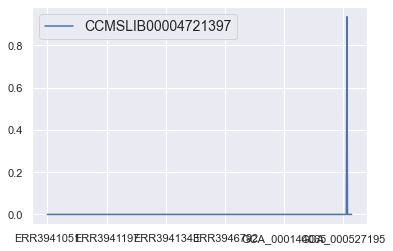

In [48]:
mf_subset1 = testing_df.loc['CCMSLIB00004721397'].T

mf_subset1.plot().legend(loc=2, prop={'size': 14})

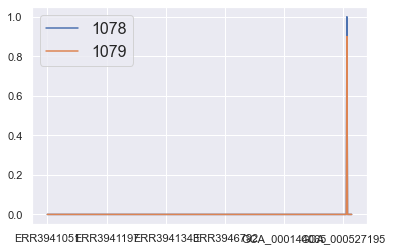

In [49]:
gcf_subset1 = training_df[training_df['label'] == 'GCF171'].T
gcf_subset1 = gcf_subset1.drop('label')

gcf_subset1.plot().legend(loc=2, prop={'size': 16})

In [50]:
bigscape_dict2['GCF171']

['GCA_001625105.region031', 'BGC0000632.1']

In [51]:
def get_feature(updated_name,name_dict):
    bgc_name = 0
    for key in name_dict.keys():
        if name_dict[key] == updated_name:
            if bgc_name == 0:
                bgc_name = key
                print(bgc_name)
                input_handle = open("/Volumes/TFL190831/ming_output/antismash/%s.fasta_output_results/%s.gbk"%(updated_name.split('.')[0],bgc_name),'r')
                for seq_record in SeqIO.parse(input_handle,'genbank'):
                    for feature in seq_record.features:
                        if feature.type == 'cand_cluster':
                            print(feature)
                

                
for candidate in bigscape_dict2['GCF171']:
    feature = get_feature(candidate,name_dict)

KV411304.1.region018
type: cand_cluster
location: [0:19249](+)
qualifiers:
    Key: candidate_cluster_number, Value: ['1']
    Key: contig_edge, Value: ['False']
    Key: detection_rules, Value: ['(Terpene_synth or Terpene_synth_C or phytoene_synt or Lycopene_cycl or terpene_cyclase or NapT7 or fung_ggpps or fung_ggpps2 or trichodiene_synth or TRI5)']
    Key: kind, Value: ['single']
    Key: product, Value: ['terpene']
    Key: protoclusters, Value: ['1']
    Key: tool, Value: ['antismash']

